In [15]:
# imports
import numpy as np
import wget
from os import path
import random
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA

# numpy conf
np.set_printoptions(precision=3, suppress=True)

In [16]:
# Descargar dataset
# Breast Cancer Wisconsin (Diagnostic) Data Set
# http://mlr.cs.umass.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

dataset_url = 'http://mlr.cs.umass.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
dataset_localfilename = 'wdbc.data'
if not path.exists(dataset_localfilename):
    wget.download(dataset_url, dataset_localfilename)

In [17]:
# Necesito reemplazar M (maligno) y B (benigno) por valores númericos en el dataset
# Seguro se puede hacer de otra forma. Si hago el reemplazo en el archivo, despues puedo cargarlo como una matriz de numpy de la forma correcta con np.genfromtxt
def replace(file_path, save_path):
    with open(save_path, 'x') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                if "M" in line :
                    new_file.write( line.replace( "M", "1" ) )
                if "B" in line :
                    new_file.write( line.replace( "B", "0" ) )

dataset_localfilename_edited = 'wdbc_edited.data'
if not path.exists(dataset_localfilename_edited):
    replace(dataset_localfilename, dataset_localfilename_edited)

In [18]:
# Carga del dataset
dataset_raw = np.genfromtxt(dataset_localfilename_edited, delimiter=',', dtype=float)
print('Dataset size: {}'.format(dataset_raw.shape))

# imprimimos las primeras 4 filas para ver qué tipo de datos tenemos
print('First 4 rows:')
print(dataset_raw[0:4,:])

Dataset size: (569, 32)
First 4 rows:
[[  842302.           1.          17.99        10.38       122.8
      1001.           0.118        0.278        0.3          0.147
         0.242        0.079        1.095        0.905        8.589
       153.4          0.006        0.049        0.054        0.016
         0.03         0.006       25.38        17.33       184.6
      2019.           0.162        0.666        0.712        0.265
         0.46         0.119]
 [  842517.           1.          20.57        17.77       132.9
      1326.           0.085        0.079        0.087        0.07
         0.181        0.057        0.543        0.734        3.398
        74.08         0.005        0.013        0.019        0.013
         0.014        0.004       24.99        23.41       158.8
      1956.           0.124        0.187        0.242        0.186
         0.275        0.089]
 [84300903.           1.          19.69        21.25       130.
      1203.           0.11         0.16      

In [19]:
# Seleccionamos etiquetas e instancias
X = dataset_raw[:,2:]
y = dataset_raw[:,1]

# chequeamos los tamaños de nuestros nuevos conjuntos
print('X size: {}'.format(X.shape))
print('y size: {}'.format(y.shape))

# imprimimos las primeras 4 filas
print('First 4 rows from the design matrix:')
print(X[0:4,:])
print('First 4 labels from the labels array:')
print(y[0:4])

# Contamos la cantidad de elementos con cada etiqueta 
print(np.unique(y, return_counts=True))

X size: (569, 30)
y size: (569,)
First 4 rows from the design matrix:
[[  17.99    10.38   122.8   1001.       0.118    0.278    0.3      0.147
     0.242    0.079    1.095    0.905    8.589  153.4      0.006    0.049
     0.054    0.016    0.03     0.006   25.38    17.33   184.6   2019.
     0.162    0.666    0.712    0.265    0.46     0.119]
 [  20.57    17.77   132.9   1326.       0.085    0.079    0.087    0.07
     0.181    0.057    0.543    0.734    3.398   74.08     0.005    0.013
     0.019    0.013    0.014    0.004   24.99    23.41   158.8   1956.
     0.124    0.187    0.242    0.186    0.275    0.089]
 [  19.69    21.25   130.    1203.       0.11     0.16     0.197    0.128
     0.207    0.06     0.746    0.787    4.585   94.03     0.006    0.04
     0.038    0.021    0.022    0.005   23.57    25.53   152.5   1709.
     0.144    0.424    0.45     0.243    0.361    0.088]
 [  11.42    20.38    77.58   386.1      0.142    0.284    0.241    0.105
     0.26     0.097    0.496  

In [20]:
# calculamos la cantidad de muestras de entrenamiento/validación y test
n_trainval = round(0.7 * X.shape[0])
n_test = X.shape[0] - n_trainval

# vamos a generar una secuencia de índices de 0 al total de muestras, con la que
# representaremos cada muestra en nuestra matriz de diseño
idx = list(range(0,X.shape[0]))
print('First 5 indices (without shuffling): {}'.format(idx[0:5]))

# ahora vamos a aleatorizar el orden de esta lista, para que ya no sean 
# consecutivos
random.shuffle(idx)
print('First 5 indices (after shuffling): {}'.format(idx[0:5]))

# si extraemos las primeras n_trainval muestras de X usando los índices
# aleatorizados que hemos generado, esto equivale a tomar unas muestra aleatoria
X_trainval = X[idx[0:n_trainval],:]
y_trainval = y[idx[0:n_trainval]]
X_test = X[idx[n_trainval:],:]
y_test = y[idx[n_trainval:]]

# verificamos sus tamaños
print('Train/val set size: {}'.format(X_trainval.shape))
print('Test set size: {}'.format(X_test.shape))

First 5 indices (without shuffling): [0, 1, 2, 3, 4]
First 5 indices (after shuffling): [56, 526, 207, 461, 561]
Train/val set size: (398, 30)
Test set size: (171, 30)


In [21]:
# calculamos la cantidad de muestras de entrenamiento y validación
n_train = round(0.9 * X_trainval.shape[0])
n_val = X_trainval.shape[0] - n_train

# si extraemos las primeras n_trainval muestras de X usando los índices
# aleatorizados que hemos generado, esto equivale a tomar unas muestra aleatoria
X_train = X[idx[0:n_train],:]
y_train = y[idx[0:n_train]]
X_val = X[idx[n_train:n_train+n_val],:]
y_val = y[idx[n_train:n_train+n_val]]

# verificamos sus tamaños
print('Training set size: {}'.format(X_train.shape))
print('Validation set size: {}'.format(X_val.shape))
print('Test set size: {}'.format(X_test.shape))

Training set size: (358, 30)
Validation set size: (40, 30)
Test set size: (171, 30)


In [22]:
# Imprimimos el porcentaje de instancias con cada una de las dos etiquetas para dataset, train y validation
print(np.unique(y, return_counts=True)[1]/np.size(y))
print(np.unique(y_train, return_counts=True)[1]/np.size(y_train))
print(np.unique(y_val, return_counts=True)[1]/np.size(y_val))

[0.627 0.373]
[0.617 0.383]
[0.725 0.275]


In [23]:
# definimos un diccionario con tags para las features que vamos a mantener y sus
# descriptiones
feature_labels = dict()
feature_labels['RAD1']='radius (mean of distances from center to points on the perimeter), mean'
feature_labels['TEX1']='texture (standard deviation of gray-scale values), mean'
feature_labels['PER1']='perimeter, mean'
feature_labels['AREA1']='area, mean'
feature_labels['SMO1']='smoothness (local variation in radius lengths), mean'
feature_labels['COMP1']='compactness (perimeter^2 / area - 1.0), mean'
feature_labels['CONC1']='concavity (severity of concave portions of the contour), mean'
feature_labels['CONCP1']='concave points (number of concave portions of the contour), mean'
feature_labels['SYM1']='índice de accessibilidad a carreteras radiales, mean'
feature_labels['FRD1']='fractal dimension ("coastline approximation" - 1), mean'
feature_labels['RAD_SE']='radius (mean of distances from center to points on the perimeter), standard error'
feature_labels['TEX_SE']='texture (standard deviation of gray-scale values), standard error'
feature_labels['PER_SE']='perimeter, standard error'
feature_labels['AREA_SE']='area, standard error'
feature_labels['SMO_SE']='smoothness (local variation in radius lengths), standard error'
feature_labels['COMP_SE']='compactness (perimeter^2 / area - 1.0), standard error'
feature_labels['CONC_SE']='concavity (severity of concave portions of the contour), standard error'
feature_labels['CONCP_SE']='concave points (number of concave portions of the contour), standard error'
feature_labels['SYM_SE']='índice de accessibilidad a carreteras radiales, standard error'
feature_labels['FRD_SE']='fractal dimension ("coastline approximation" - 1), standard error'
feature_labels['RAD_EW']='radius (mean of distances from center to points on the perimeter), extreme worst'
feature_labels['TEX_EW']='texture (standard deviation of gray-scale values), extreme worst'
feature_labels['PER_EW']='perimeter, extreme worst'
feature_labels['AREA_EW']='area, extreme worst'
feature_labels['SMO_EW']='smoothness (local variation in radius lengths), extreme worst'
feature_labels['COMP_EW']='compactness (perimeter^2 / area - 1.0), extreme worst'
feature_labels['CONC_EW']='concavity (severity of concave portions of the contour), extreme worst'
feature_labels['CONCP_EW']='concave points (number of concave portions of the contour), extreme worst'
feature_labels['SYM_EW']='índice de accessibilidad a carreteras radiales, extreme worst'
feature_labels['FRD_EW']='fractal dimension ("coastline approximation" - 1), extreme worst'

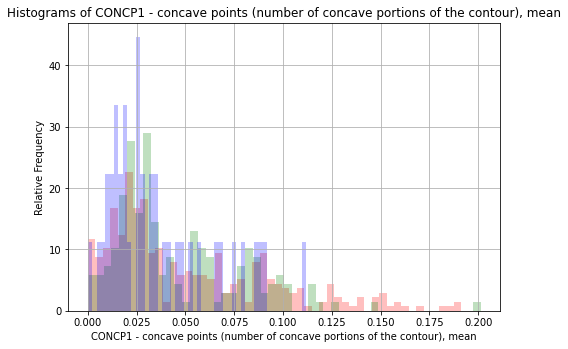

In [24]:
# modificar esta variable con el índice de la feature que se quiere analizar
variable_to_print = 7
relative_frequency = True

# modificar esta variable para determinar el número de baldes que vamos a usar
n_bins = 50

# recuperamos su tag y un string con su tag y descripción
tag = list(feature_labels.keys())[variable_to_print]
feature_id_and_description = tag + ' - ' + feature_labels[tag]

# creamos el canvas de la figura
fig=plt.figure()
# agregamos los ejes
ax=fig.add_axes([0,0,1,1])
# hacemos histogramas de 50 baldes para los datos de entrenamiento, validación y
# test, en los colores azul (b), verde (g) y rojo (r), con cierta transparencia 
# alpha
ax.hist(X_train[:,variable_to_print], n_bins, density=relative_frequency, facecolor='r', alpha=0.25)
ax.hist(X_test[:,variable_to_print], n_bins, density=relative_frequency, facecolor='g', alpha=0.25)
ax.hist(X_val[:,variable_to_print], n_bins, density=relative_frequency, facecolor='b', alpha=0.25)
# agregamos las etiquetas de los ejes x e y
ax.set_xlabel(feature_id_and_description)
if relative_frequency:
  ax.set_ylabel('Relative Frequency')
else:
  ax.set_ylabel('Absolute Frequency')
# le colocamos un título
ax.set_title('Histograms of {}'.format(feature_id_and_description))
ax.grid(True)
# lo mostramos por pantalla
plt.show()

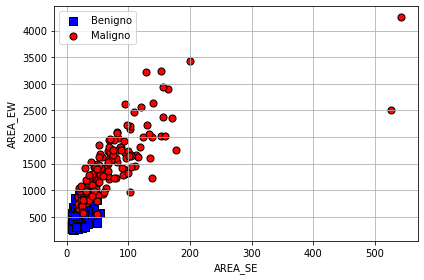

In [25]:
# Scatterplot de 2 features y clustering con las etiquetas sobre el training dataset

# Elegimos 2 features
feature1 = 13
feature2 = 23

# Y obtenemos sus tags
tag1 = list(feature_labels.keys())[feature1]
tag2 = list(feature_labels.keys())[feature2]

# Hacemos el scatterplot en dos partes, segun la etiqueta es 0 o 1
plt.scatter(X_train[y_train == 0, feature1],
            X_train[y_train == 0, feature2],
            s=50, c='blue',
            marker='s', edgecolor='black',
            label='Benigno')
plt.scatter(X_train[y_train == 1, feature1],
            X_train[y_train == 1, feature2],
            s=50, c='red',
            marker='o', edgecolor='black',
            label='Maligno')
plt.xlabel(tag1)
plt.ylabel(tag2)
plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()

plt.show()

In [26]:
# estimamos media y desvío a partir de los datos de entrenamiento
mu = np.mean(X_train, axis=0)
sigma = np.std(X_train, axis=0)

# los imprimimos para ver cómo eran
print('X_train:')
print('Mean')
print(mu)
print('Std')
print(sigma)

# lo aplicamos sobre los datos de entrenamiento, validación y test
X_train_stand = (X_train - mu) / sigma

# imprimimos los valores que nos quedan ahora
print('\nX_train_stand:')
print('Mean')
print(np.mean(X_train_stand, axis=0))
print('Std')
print(np.std(X_train_stand, axis=0))

# repetimos la operación sobre los datos de validación y test
X_val_stand = (X_val - mu) / sigma
X_test_stand = (X_test - mu) / sigma

# estimamos media y desvío a partir de los datos de entrenamiento
mu = np.mean(X_train, axis=0)
sigma = np.std(X_train, axis=0)
# los imprimimos para ver cómo eran
print('X_train:')
print('Mean')
print(mu)
print('Std')
print(sigma)

# lo aplicamos sobre los datos de entrenamiento, validación y test
X_train_stand = (X_train - mu) / sigma

# imprimimos los valores que nos quedan ahora
print('\nX_train_stand:')
print('Mean')
print(np.mean(X_train_stand, axis=0))
print('Std')
print(np.std(X_train_stand, axis=0))

# repetimos la operación sobre los datos de validación y test
X_val_stand = (X_val - mu) / sigma
X_test_stand = (X_test - mu) / sigma

# salvamos los datos para usarlos más adelante
datasets_folder = ''
print('\nSaving {}'.format(path.join(datasets_folder, 'wdbc_dataset_partitioned.pkl')))
with open(path.join(datasets_folder, 'wdbc_dataset_partitioned.pkl'), 'wb') as f:
    partitioned_dataset = {'X_train': X_train_stand, 'X_val': X_val_stand, 'X_test': X_test_stand,
                           'y_train': y_train, 'y_val': y_val, 'y_test': y_test,
                           'feature_labels': feature_labels, 'mu': mu, 'sigma': sigma}
    pickle.dump(partitioned_dataset, f)

X_train:
Mean
[ 14.349  19.293  93.526 679.041   0.097   0.107   0.095   0.052   0.184
   0.063   0.422   1.181   2.994  43.181   0.007   0.026   0.033   0.012
   0.021   0.004  16.605  25.537 109.64  922.93    0.133   0.264   0.288
   0.119   0.295   0.085]
Std
[  3.74    4.428  25.868 379.955   0.014   0.057   0.087   0.042   0.028
   0.007   0.303   0.536   2.214  51.235   0.003   0.018   0.033   0.006
   0.008   0.003   5.166   6.288  35.967 616.678   0.024   0.169   0.228
   0.07    0.067   0.02 ]

X_train_stand:
Mean
[-0. -0. -0. -0.  0. -0. -0. -0. -0.  0.  0. -0.  0.  0. -0. -0.  0. -0.
 -0.  0.  0.  0.  0. -0.  0. -0. -0. -0. -0. -0.]
Std
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
X_train:
Mean
[ 14.349  19.293  93.526 679.041   0.097   0.107   0.095   0.052   0.184
   0.063   0.422   1.181   2.994  43.181   0.007   0.026   0.033   0.012
   0.021   0.004  16.605  25.537 109.64  922.93    0.133   0.264   0.288
   0.119   0.295  

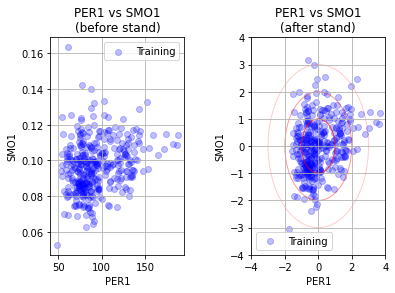

In [27]:
# modificar esta variable con los índices de las características que queremos
# comparar
variables_to_compare = [2, 4]
tags = list([None]) * len(variables_to_compare)
for i in range(len(variables_to_compare)):
  tags[i] = list(feature_labels.keys())[variables_to_compare[i]]

# generamos un scatter plot con los datos antes de estandarizar
fig, (ax1, ax2) =plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.5)
ax1.scatter(X_train[:,variables_to_compare[0]], X_train[:,variables_to_compare[1]], facecolor='b', alpha=0.25)
ax1.grid(True)
ax1.set_xlabel(tags[0])
ax1.set_ylabel(tags[1])
ax1.legend(['Training'])
ax1.set_title('{} vs {}\n(before stand)'.format(tags[0], tags[1]))

# generamos un scatter plot con los datos estandarizados
ax2.scatter(X_train_stand[:,variables_to_compare[0]], X_train_stand[:,variables_to_compare[1]], facecolor='b', alpha=0.25)
circle1 = plt.Circle((0, 0), 1, color='r', alpha=0.7, fill=False)
circle2 = plt.Circle((0, 0), 2, color='r', alpha=0.4, fill=False)
circle3 = plt.Circle((0, 0), 3, color='r', alpha=0.2, fill=False)
ax2.add_artist(circle1)
ax2.add_artist(circle2)
ax2.add_artist(circle3)
ax2.set_xlim(-4, 4)
ax2.set_ylim(-4, 4)
ax2.grid(True)
ax2.set_xlabel(tags[0])
ax2.set_ylabel(tags[1])
ax2.legend(['Training'])
ax2.set_title('{} vs {}\n(after stand)'.format(tags[0], tags[1]))

plt.show()

Before PCA: (358, 30)
After PCA: (358, 2)


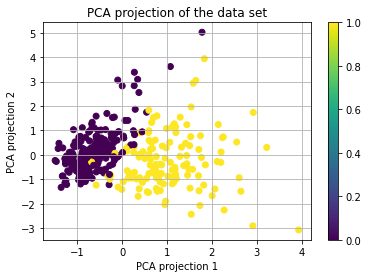

In [28]:
# declaramos un objeto PCA que mapee n dimensions a p=2, y que además
# normalice esas features (whiten=True)
pca = PCA(n_components=2, whiten=True)

# le pedimos al objeto que se ajuste utilizando los datos de entrenamiento
pca = pca.fit(X_train_stand)

# aplicamos la transformación aprendida sobre los datos de entrenamiento
X_train_stand_pca = pca.transform(X_train_stand)

# imprimimos los tamaños antes y después
print('Before PCA: {}'.format(X_train_stand.shape))
print('After PCA: {}'.format(X_train_stand_pca.shape))

# graficamos los datos. el color de cada punto representa el valor de la casa
plt.scatter(X_train_stand_pca[:,0], X_train_stand_pca[:,1], c=y_train, cmap='viridis')
plt.grid(True)
plt.xlabel('PCA projection 1')
plt.ylabel('PCA projection 2')
plt.title('PCA projection of the data set')
plt.colorbar()
plt.show()